In [1]:
from scipy.io import savemat, loadmat
import pandas as pd
import pdb
import json
import numpy as np
from numpy import median, mean
from sklearn.linear_model import BayesianRidge, LinearRegression, RidgeCV, Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score, LeaveOneOut
import pickle
import matplotlib.pyplot as plt

In [2]:
ac = loadmat('./data/Train_comb_NN_model.mat')

y = ac['y']
y = y.flatten()

alphas = np.logspace(-6, 6, 200)


Xrc = ac['X_comb_train']
regr_rcombined = RidgeCV(alphas=alphas,fit_intercept= False).fit(Xrc, y)

y_pred_rc = regr_rcombined.predict(Xrc)
mse_rc = mean_squared_error(y, y_pred_rc)
r2 = r2_score(y, y_pred_rc)


print('radius 1+2 linear model')
print('Mean squared error: %.2f'
    % mse_rc)
print('Coefficient of determination: %.4f'
    % r2)


radius 1+2 linear model
Mean squared error: 9.60
Coefficient of determination: 0.9998


Text(0.7,0.25,'$R^2$ = 0.9998')

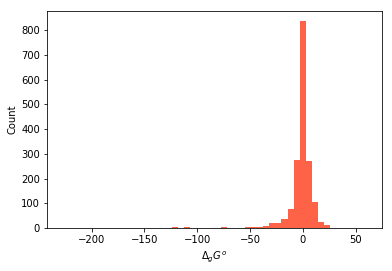

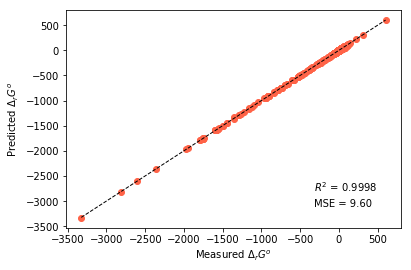

In [3]:
plt.hist(regr_rcombined.coef_[0:1730], bins=50, color = 'tomato')#for ridgeCV

plt.xlabel('$\Delta_g G^o$')
plt.ylabel('Count')
# plt.savefig('./figures/ridge_group_info_radius2_manual_correct_new_color.png')

fig, ax = plt.subplots()
# ax.scatter(y, predicted, color = 'burlywood')
ax.scatter(y, y_pred_rc, color = 'tomato')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=1,)
ax.set_xlabel('Measured $\Delta_r G^o$')
ax.set_ylabel('Predicted $\Delta_r G^o$')
plt.figtext(.7, .2, "MSE = %.2f" % mse_rc)
plt.figtext(.7, .25, "$R^2$ = %.4f" % r2)



In [3]:
r1_d = loadmat('./data/dGPredictor_stereo.mat')
r2_d = loadmat('./data/radius2_mat_data_modified_manual.mat')
S = r1_d['train_S']

Gr1 = r1_d['G']
Gr2 = r2_d['G_inc_r2_compar']

df_S = pd.DataFrame(r1_d['train_S'])
df_S_unique = df_S.T.drop_duplicates().T
unque_cols = df_S_unique.columns.values.tolist()
S = S[:, unque_cols]

b_list = json.load(open('./data/median_b_manual_correction_r2.json')) # it will be same for both radius, it just remove all the repeated data points from the training data
b = np.asarray(b_list)
b = np.reshape(b,(-1,1))

STG1 = np.dot(S.T, Gr1)
STG2 = np.dot(S.T, Gr2)


X1 = STG1
X2 = STG2
yy = b
yy = yy.flatten()


## cross validation combined moiety model

XX = np.concatenate((X1, X2), axis =1)

alphas = np.logspace(-6, 6, 200)
regr = RidgeCV(alphas=alphas,fit_intercept= False).fit(XX, yy)

regr_cv = Ridge(alpha=regr.alpha_,fit_intercept=False)
scores_cv = -cross_val_score(regr_cv, XX, yy, cv=LeaveOneOut(), scoring='neg_mean_absolute_error')


print('cross-validataion result : radius 1 + 2')
print('median of cv is: ', median(scores_cv))
print('mean of cv is: ', mean(scores_cv))

cross-validataion result : radius 1 + 2
('median of cv is: ', 5.484989593117513)
('mean of cv is: ', 16.25610650703227)


## Test case KEGG dataset 

In [23]:
ac = loadmat('./data/Test_KEGG_comb_all_grp_NN_model.mat')

y = ac['y']
y = y.flatten()

alphas = np.logspace(-6, 6, 200)

Xrc = ac['X_comb_all']
regr_rcombined = BayesianRidge(tol=1e-6, fit_intercept=False, compute_score=True).fit(Xrc, y)

y_pred_rc = regr_rcombined.predict(Xrc)
mse_rc = mean_squared_error(y, y_pred_rc)
r2 = r2_score(y, y_pred_rc)


print('radius 1+2 linear model')
print('Mean squared error: %.2f'
    % mse_rc)
print('Coefficient of determination: %.4f'
    % r2)


radius 1+2 linear model
Mean squared error: 9.60
Coefficient of determination: 0.9998


In [114]:
df = (pd.read_csv("./data/reaction_rule.csv", index_col=0))
df2 = (pd.read_csv("./data/reaction_rule_r2_py3_manual_modified.csv", index_col=0))

In [17]:
rule_vec1 = df.to_numpy().T
rule_vec2 = df2.to_numpy().T

m, n = rule_vec1.shape
m2, n2 = rule_vec2.shape

zeros1 = np.zeros((m, 44))
zeros2 = np.zeros((m2, 44))

In [21]:
X1 = rule_vec1
X1 = np.concatenate((rule_vec1,zeros1),1)

X2 = rule_vec2
X2 = np.concatenate((rule_vec2,zeros2),1)

X_comb_all = np.concatenate((X1, X2), axis =1)

In [25]:
ymean, ystd = regr_rcombined.predict(X_comb_all, return_std=True)

In [26]:
rxns = df.columns.tolist()

In [33]:
result = {}
result['reaction'] = rxns
result['dG'] = ymean
result['dG_std'] = ystd
df_result = pd.DataFrame.from_dict(result)
df_result.to_csv('./result/result_M1_2Linear_comb_model_Kegg_all.csv', index = False)

## Analysis Section 2.3

In [49]:
# read groups that exist in thermodynamic data

df_groups1 = pd.read_csv('./data/group_names_TECRDB.txt',header=None)
groups1 = df_groups1[0].tolist()


df_groups2 = pd.read_csv('./data/r2_grp_TECRDB_name.txt',header=None)
groups2 = df_groups2[0].tolist()

In [81]:
grps_all = groups1 + groups2

In [91]:
df.shape

(1435, 7053)

In [92]:
df2.shape

(24881, 7053)

In [94]:
# frames = [df, df2]
df_all = pd.concat([df, df2])

C:\Users\vuu10\AppData\Local\Continuum\anaconda3\envs\new_env\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [95]:
df_all.shape

(26316, 7053)

In [83]:
df_rule_1 = df_all.drop(grps_all)

In [97]:
df_rule_2 = df_rule_1.loc[:, (df_rule_1 != 0).any(axis=0)] 

In [98]:
df_rule_2.shape

(1172, 2166)

In [102]:
(7053.0 -2166.0 )*100.0 /7053.0

69.28966397277755

In [189]:
7053-2166 

4887

# reactions with zero group changes using component contribution

In [105]:
coef = regr_rcombined.coef_
sigma = regr_rcombined.sigma_

In [106]:
cov = [np.sqrt(sigma[i][i]) for i in range(len(sigma))]

In [108]:
info = dict()
info['coef'] = coef
info['cov'] = cov
df_info = pd.DataFrame.from_dict(info)

In [126]:
df_info1 = df_info[:1435] # leaving 44 entries for the zeroes that were added in the data and only account for the moieties 
df_info2 = df_info[1479:26360]

In [120]:
df_info.shape
grps_df1 = pd.read_csv('./data/group_names_all.txt',header=None)
grps_df2 = pd.read_csv('./data/group_names_r2_py3_modified_manual.txt',header=None)

In [124]:
 len(grps_df1) + 44

1479

In [133]:
df_info_all = pd.concat([df_info1, df_info2])
grps_info_all = pd.concat([grps_df1, grps_df2])

In [ ]:
df_info1['group'] = grps_df1

In [154]:
df_info2 = df_info2.drop(columns=['group', 'groups']);

In [161]:
grps_df2.index = range(1479, 26360, 1)
grps_df2;

In [164]:
df_info2['group'] = grps_df2
# df_info2;

In [170]:
df_TECRDB1 = df_info1[df_info1['group'].isin(groups1)]
df_TECRDB2 = df_info2[df_info2['group'].isin(groups2)]

df_TECRDB_all = pd.concat([df_TECRDB1, df_TECRDB2])


Text(0,0.5,"$\\Delta G^{o'}$")

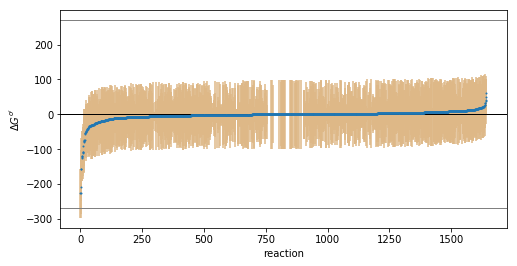

In [174]:
df_TECRDB_all = df_TECRDB_all.sort_values('coef')
mean = df_TECRDB_all['coef']
std  = df_TECRDB_all['cov']

fig, ax = plt.subplots(figsize=(8,4))
ax.errorbar(range(0,len(df_TECRDB_all.index)), mean, yerr=3*std, markersize='1',fmt='o', ecolor='burlywood', capthick=1)#,alpha=0.4)
ax.axhline(y=0,linewidth=1,color='k')

ax.axhline(y=270,linewidth=1,color='grey')
ax.axhline(y=-270,linewidth=1,color='grey')
ax.fill_between(range(0,len(df_TECRDB_all.index)), -270, 270, alpha=0.2, color='white')
plt.xlabel('reaction')
plt.ylabel('$\Delta G^{o\'}$')
# ax.errorbar(prediction.reaction, mean, yerr=std, fmt='-o') #fmt=None to plot bars only

Text(0,0.5,'Count')

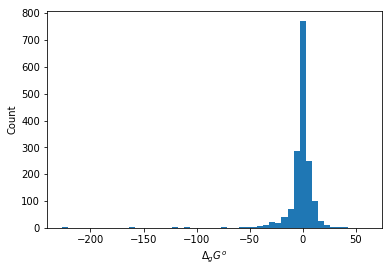

In [180]:
plt.hist(df_TECRDB_all['coef'], bins=50)
# plt.xscale('log')
plt.xlabel('$\Delta_g G^o$')
plt.ylabel('Count')

In [186]:
df_TECRDB_all[(df_TECRDB_all['coef']<1e-3) & (df_TECRDB_all['coef']>-1e-3)]

,coef,cov,group
794,-5.459416e-13,23.594649,S
17822,-5.459416e-13,23.594649,S
25109,0.000000e+00,0.000000,ccc(cc)C(N)=O
3843,0.000000e+00,8.805414,CC(=C)C(C)(C)CC
13024,0.000000e+00,0.000000,C[C@@H](O)C[NH2+]C
15077,0.000000e+00,0.000000,C[C@H](O)C(=O)NC
21118,0.000000e+00,0.000000,c[C@@H](C)[C@@H](CC)[C@H](C)C
15083,0.000000e+00,0.000000,C[C@H](O)C(=O)[C@H](C)O
15220,0.000000e+00,0.000000,C[C@H](O)[C@@H](C)OC
21865,0.000000e+00,0.000000,c[nH+]cn(c)C


In [188]:
df_TECRDB_all[(df_TECRDB_all['coef']<-225)]

,coef,cov,group
869,-226.531632,23.591848,[Mg+2]
17931,-226.531632,23.591848,[Mg+2]


## analyze groups contribution 

In [190]:
regr_rcombined.alpha_

0.09299612677498964

In [194]:
alpha_val = regr_rcombined.lambda_

In [195]:
std_dev_dg_group = np.sqrt(1/alpha_val)
std_dev_dg_group

33.29056126498055

# analyze zero group change

## component contribution reactions with zero group changes

In [203]:
df_cc = pd.read_csv('./data/rule_cc.csv',index_col=0)
all_zeros = df_cc.loc[:, (df_cc == 0).all()]
rxns_zeros = all_zeros.columns.tolist()
len(rxns_zeros)


319

In [202]:
db = pd.read_excel('./data/optstoic_v3_complete_table.xlsx')

In [204]:
dframe = db[db['reaction_id'].isin(rxns_zeros)]

In [209]:
first_digit = []

for a in dframe['EC_number'].tolist():
#     print(a)
    if '.' in str(a):
        first_digit.append(a[0])
    else:
        first_digit.append(None)
# first_digit = pd.DataFrame(first_digit).reset_index()

dframe['EC_first_digit'] = first_digit

C:\Users\vuu10\AppData\Local\Continuum\anaconda3\envs\new_env\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [197]:
df_all.head()

,FACOAE120,R00004,R00005,R00006,R00008,R00009,R00010,R00011,R00012,R00013,...,R11107,R11113,R11114,R11115,R11116,R11117,R11118,R11119,R11124,R11125
BO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Bc(c)c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BrC(Br)Br,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C#C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [212]:
all_ac = df_all.loc[:, (df_all == 0).all()]
rxns_zeros_ac = all_ac.columns.tolist()
len(rxns_zeros_ac)

43

In [214]:
df_all1 = dframe[~dframe['reaction_id'].isin(rxns_zeros_ac)]

In [215]:
df_all1.shape

(277, 28)

In [217]:
319-277

42

In [218]:
tmp = []
for i,r in enumerate(dframe['reaction_id'].tolist()):
    if r in rxns_zeros_ac:
        tmp.append(None)
    else:
        tmp.append(first_digit[i])

dframe['EC_first_digit_dGPredictor'] =tmp 

C:\Users\vuu10\AppData\Local\Continuum\anaconda3\envs\new_env\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


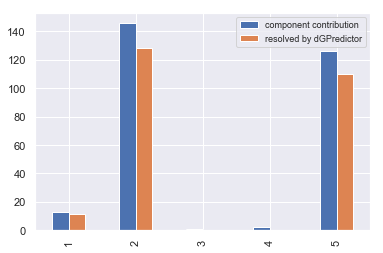

In [223]:
ax = dframe[['EC_first_digit','EC_first_digit_dGPredictor']].apply(pd.Series.value_counts).plot(kind="bar")
ax.legend(["component contribution", "resolved by dGPredictor"], loc='best',prop={'size': 9})#,bbox_to_anchor=(1.0, 0.5))

In [225]:
dframe[['EC_first_digit','EC_first_digit_dGPredictor']].apply(pd.Series.value_counts)

,EC_first_digit,EC_first_digit_dGPredictor
1,13,11.0
2,146,128.0
3,1,NaN
4,2,NaN
5,126,110.0


In [229]:
13+146+1+2+126

288

In [230]:
5 + 54+93

152

In [231]:
319-288

31

In [233]:
dframe.to_csv('./result/analyze_zero_group_change.csv')

In [234]:
df_all2 = dframe[dframe['reaction_id'].isin(rxns_zeros_ac)]

In [271]:
df_all2.head()

,reaction_id,description,EC_number,reaction_elemental_balance,new_reaction_enter_db,reaction_equation,reaction,reaction_formula,old_database_dG0prime (kcal/mol),old_database_reaction_type,...,dG_cannot_estimate_by_component_contribution,pH_7.0_dG_prime_lo (kJ/mol),pH_7.0_dG_prime_up (kJ/mol),rxntype_curated,rxntype_from_dG,reaction_type,lower_bound (mmol/gDW h),upper_bound (mmol/gDW h),EC_first_digit,EC_first_digit_dGPredictor
39,R00062,bilirubin-glucuronoside:bilirubin-glucuronosid...,2.4.1.95,All balanced,1,2 Bilirubin-glucuronoside <=> Bilirubin + Bili...,2 C03374 <=> C00486 + C05787,2 C39H44N4O12 <=> C33H36N4O6 + C45H52N4O18,-0.1,1.0,...,1,0.000000,0.000000,NaN,1,1,-1000,1000,2,None
71,R00112,NADPH:NAD+ oxidoreductase,1.6.1.1;1.6.1.2;1.6.1.3,All balanced,1,NADPH + NAD+ <=> NADP+ + NADH,C00005 + C00003 <=> C00006 + C00004,C21H30N7O17P3 + C21H28N7O14P2 <=> C21H29N7O17P...,1.7,1.0,...,0,-58.056398,56.097440,NaN,1,1,-1000,1000,1,None
91,R00139,ATP:2'-deoxy-5-hydroxymethylcytidine-5'-diphos...,2.7.4.6,All balanced,1,2'-Deoxy-5-hydroxymethylcytidine-5'-diphosphat...,C11038 + C00002 <=> C11039 + C00008,C10H17N3O11P2 + C10H16N5O13P3 <=> C10H18N3O14P...,0.0,1.0,...,0,-54.412978,59.740860,NaN,1,1,-1000,1000,2,None
99,R00156,ATP:UDP phosphotransferase,2.7.4.6,All balanced,1,ATP + UDP <=> ADP + UTP,C00002 + C00015 <=> C00008 + C00075,C10H16N5O13P3 + C9H14N2O12P2 <=> C10H15N5O10P2...,0.0,1.0,...,0,-59.423639,54.730200,NaN,1,1,-1000,1000,2,None
217,R00330,ATP:GDP phosphotransferase,2.7.4.6,All balanced,1,ATP + GDP <=> ADP + GTP,C00002 + C00035 <=> C00008 + C00044,C10H16N5O13P3 + C10H15N5O11P2 <=> C10H15N5O10P...,0.0,1.0,...,0,-59.548720,54.605118,NaN,1,1,-1000,1000,2,None


In [236]:
df_all2

1

In [240]:
type(ymean)

numpy.ndarray

In [258]:
zero_dg_rxn = np.where(ymean == 0)
zero_dg_rxn = list(zero_dg_rxn)
zero_dg_rxn = zero_dg_rxn[0]

In [262]:
rxn_zero = []
for i in zero_dg_rxn:
    temp = i
    rxn_zero.append(rxns[i])

In [263]:
rxn_zero

['R01857',
 'R03181',
 'R00722',
 'R04538',
 'R00576',
 'R03154',
 'R00119',
 'R01109',
 'R07832']

In [269]:
df_all2[['reaction_id', 'EC_first_digit','EC_first_digit_dGPredictor']]

,reaction_id,EC_first_digit,EC_first_digit_dGPredictor
39,R00062,2,None
71,R00112,1,None
91,R00139,2,None
99,R00156,2,None
217,R00330,2,None
244,R00363,5,None
373,R00570,2,None
399,R00616,2,None
407,R00647,1,None
473,R00722,2,None
